In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from datetime import datetime

from data_visualization_service import data_visualization_service
from data_validation_service import data_validation_service

data = pd.read_csv("product.csv")

## Context
Dataset contains orders, user session information, and promotional banners shown. \
Try to optimize sales

In [2]:
# preview of data
data.head()

,order_id,user_id,page_id,product,site_version,time,title,target
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,6f4922f45568161a8cdf4ad2299f6d23,sneakers,desktop,2019-01-11 09:24:43,banner_click,0
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471220 entries, 0 to 8471219
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   order_id      object
 1   user_id       object
 2   page_id       object
 3   product       object
 4   site_version  object
 5   time          object
 6   title         object
 7   target        int64 
dtypes: int64(1), object(7)
memory usage: 517.0+ MB


## Step 0: Data Understanding

## Step 1: data validation -> check data integrity

In [5]:
#checking for null values anywhere 
validation_svc = data_validation_service(data)
validation_svc.get_columns_with_null_percentage()

order_id  :  0.0  null percentage
user_id  :  0.0  null percentage
page_id  :  0.0  null percentage
product  :  0.0  null percentage
site_version  :  0.0  null percentage
time  :  0.0  null percentage
title  :  0.0  null percentage
target  :  0.0  null percentage


In [6]:
#does any one user show up twice in the data?
validation_svc.set_primary_key_column("user_id")
validation_svc.get_ids_with_multiple_rows()

                                 order_id                           user_id  \
2        c81e728d9d4c2f636f067f89cc14862c  eccbc87e4b5ce2fe28308fd9f2a7baf3   
3        eccbc87e4b5ce2fe28308fd9f2a7baf3  eccbc87e4b5ce2fe28308fd9f2a7baf3   
4        a87ff679a2f3e71d9181a67b7542122c  eccbc87e4b5ce2fe28308fd9f2a7baf3   
9        45c48cce2e2d7fbdea1afc51c7c6ad26  8f14e45fceea167a5a36dedd4bea2543   
11       6512bd43d9caa6e02c990b0a82652dca  c9f0f895fb98ab9159f51fd0297e236d   
...                                   ...                               ...   
8471196  d537ff9be71436e5f05badf94c06cfb5  1944f7ee00bf0957536286e1b3ba0298   
8471197  90e4e2454f09da77d887572fa2e3276f  1944f7ee00bf0957536286e1b3ba0298   
8471201  fd7975276f53a7c4b6a2cd2857cb5c1f  0763efbac6631e6f2c01ddf9c01287dd   
8471213  56132ca28d7144c088bd1209bda91d0c  065956e2a6874f2dcafd4326fc553aed   
8471214  434f6abfee98a50394d1e210ebfddab8  065956e2a6874f2dcafd4326fc553aed   

                                  page_id          

In [7]:
#take a sneak peek of what a user with multiple rows look like 
data[data['user_id'] == 'eccbc87e4b5ce2fe28308fd9f2a7baf3']

,order_id,user_id,page_id,product,site_version,time,title,target
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0


for this user, it looks like they were shown multiple ads, but only clicked on one of them, yet did not buy anything.

### Data Transformation 
Since we are dealing with time, we might want to analyze time components individually

In [13]:
def convert_string_to_datetime(datetime_string):
    format_time = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(datetime_string, format_time)
def get_weekday_name_from_datetime(datetime_obj):
    return datetime_obj.strftime('%A')
def get_month_from_datetime(datetime_obj):
    return datetime_obj.month
def get_hour_from_datetime(datetime_obj):
    return datetime_obj.hour
def get_daytime_classification(hour):
    if hour > 6 and hour < 12:
        return 'morning'
    elif hour > 12 and hour < 18: 
        return 'afternoon'
    elif hour > 18 and hour < 24:
        return 'evening'
    else:
        return 'night'


In [22]:

data['datetime'] = data['time'].apply(convert_string_to_datetime)
data['weekday'] = data['datetime'].apply(get_weekday_name_from_datetime)
data['month'] = data['datetime'].apply(get_month_from_datetime)
data['hour'] = data['datetime'].apply(get_hour_from_datetime)
data['daytime'] = data['hour'].apply(get_daytime_classification)

In [29]:
data[data['user_id'] == 'eccbc87e4b5ce2fe28308fd9f2a7baf3']

,order_id,user_id,page_id,product,site_version,time,title,target,datetime,weekday,month,hour,daytime
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0,2019-01-09 09:38:51,Wednesday,1,9,morning
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0,2019-01-09 09:12:45,Wednesday,1,9,morning
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0,2019-01-03 08:58:18,Thursday,1,8,morning
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0,2019-01-03 08:59:15,Thursday,1,8,morning


### User-Level Information
now, we will try to compute user level information
for each user, we will be interested in three categories : retention, engagement, and revenue.

-- retention 
A). days since first appearance and most recent appearance on website

-- engagement 
A). click-through-rate :- banner_clicks / (banner_show)

-- Revenue Metrics
A). number of orders they had on their history
B). number of purchases they had 

In [30]:
trial_data = data[data['user_id'] == 'eccbc87e4b5ce2fe28308fd9f2a7baf3']

In [108]:
trial_data

,order_id,user_id,page_id,product,site_version,time,title,target,datetime,weekday,month,hour,daytime,last_appearance_date,first_appearance_date
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0,2019-01-09 09:38:51,Wednesday,1,9,morning,NaN,NaN
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0,2019-01-09 09:12:45,Wednesday,1,9,morning,NaN,NaN
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0,2019-01-03 08:58:18,Thursday,1,8,morning,NaN,NaN
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0,2019-01-03 08:59:15,Thursday,1,8,morning,NaN,NaN


In [128]:
trial_data_grouped_v2 = trial_data.groupby(["user_id"]).agg(
        last_appearance_date = ("datetime", "max")
        , first_appearance_date = ("datetime", "min")
        , num_banner_shows = ("title", lambda x: (x == "banner_show").sum())
        , num_banner_clicks = ("title", lambda x: (x == "banner_click").sum())
        , num_visits = ("target", "count")
        , num_orders = ("target", lambda x: (x>0).sum())
        , days_since_first_appearance = ("datetime", lambda x: (x.max() - x.min()).days)
        , click_thru_rate = ("title", lambda x: (x == "banner_click").sum() / (x == "banner_show").sum())
)

In [129]:
trial_data_grouped_v2

,last_appearance_date,first_appearance_date,num_banner_shows,num_banner_clicks,num_visits,num_orders,days_since_first_appearance,click_thru_rate
user_id,,,,,,,,
eccbc87e4b5ce2fe28308fd9f2a7baf3,2019-01-09 09:38:51,2019-01-03 08:58:18,3,1,4,0,6,0.333333


In [106]:
trial_data_grouped = trial_data.groupby(["user_id"])['time'].agg([np.max, np.min]).rename(columns={"max":'last_appearance_date', "min": "first_appearance_date"})
rev_metrics_grouped = trial_data.groupby(['user_id'])['target'].agg(['count', lambda x: (x>0).sum()]).rename(columns)

In [135]:
user_metrics_grouped = data.groupby(["user_id"]).agg(
        last_appearance_date = ("datetime", "max")
        , first_appearance_date = ("datetime", "min")
        #, num_banner_shows = ("title", lambda x: (x == "banner_show").sum())
        #, num_banner_clicks = ("title", lambda x: (x == "banner_click").sum())
        , num_visits = ("target", "count")
        , num_orders = ("target", lambda x: (x>0).sum())
        #, days_since_first_appearance = ("datetime", lambda x: (x.max() - x.min()).days)
        #, click_thru_rate = ("title", lambda x: (x == "banner_click").sum() / (x == "banner_show").sum())
)

In [136]:
user_metrics_grouped

,last_appearance_date,first_appearance_date,num_visits,num_orders
user_id,,,,
0000023f507999464aa2b78875b7e5d6,2019-05-14 18:00:05,2019-05-14 18:00:05,1,0
000009891526c0ade7180f8423792063,2019-05-26 06:40:32,2019-05-26 06:40:32,1,0
00000ce845c00cbf0686c992fc369df4,2019-04-27 14:02:23,2019-04-27 14:02:23,1,0
00000f7264c27ba6fea0c837ed6aa0aa,2019-05-19 16:38:05,2019-05-19 16:38:05,1,0
0000104cd168386a335ba6bf6e32219d,2019-04-12 23:15:50,2019-01-22 12:41:53,4,1
...,...,...,...,...
ffffe3323c6b5c056c19b2722c9aacbc,2019-04-09 09:26:16,2019-04-09 09:26:08,2,0
fffff8d603b897bb8655858430adfe40,2019-05-15 16:35:18,2019-04-22 13:24:03,8,0
fffff9055756ed29a5aa13ee8e222ac8,2019-03-31 10:22:45,2019-03-31 10:22:39,2,0


### Visualization -> Univariate

In [159]:
dvs = data_visualization_service(data)
dvs.set_visualization_exclusion_columns(['order_id', 'user_id', 'datetime', 'time', 'page_id'])

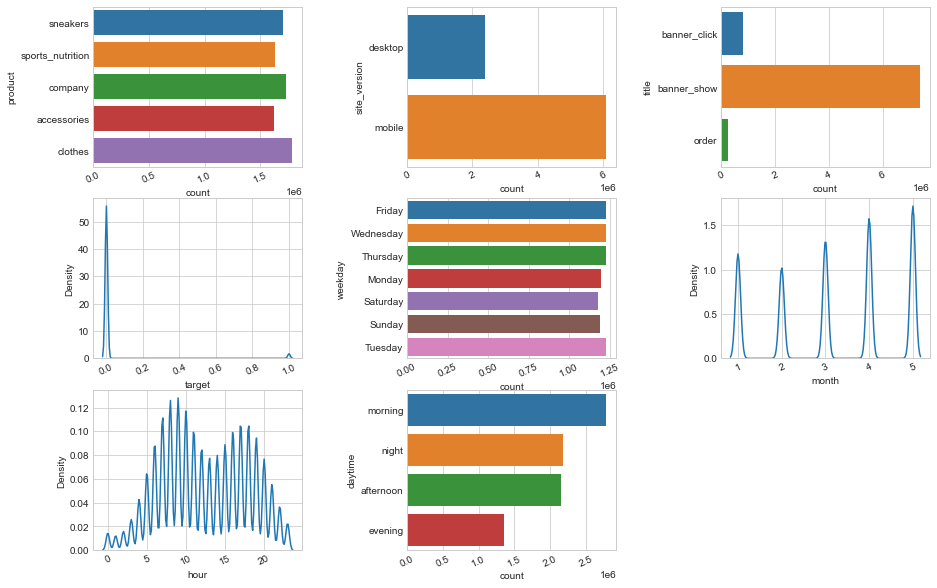

In [160]:
dvs.plot_distributions()

### Quick Findings:
Products are viewed relatively equally. \
Mobile visits are nearly 3x desktop visits. \
There seems to be equal number of visits across all the days. \
Banners are shown many more times than they are clicked, and of that, a smaller percentage resulted in an order. \
Most of the visits happen during 8 am to around 4-5 pm. \

### Joint Distribution Visualization

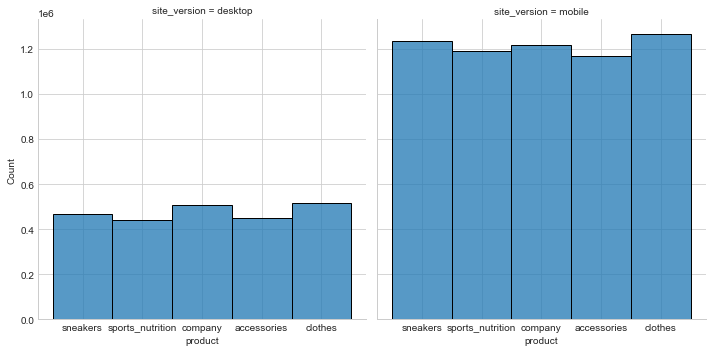

In [164]:
sns.displot(data=data, x='product', col='site_version')

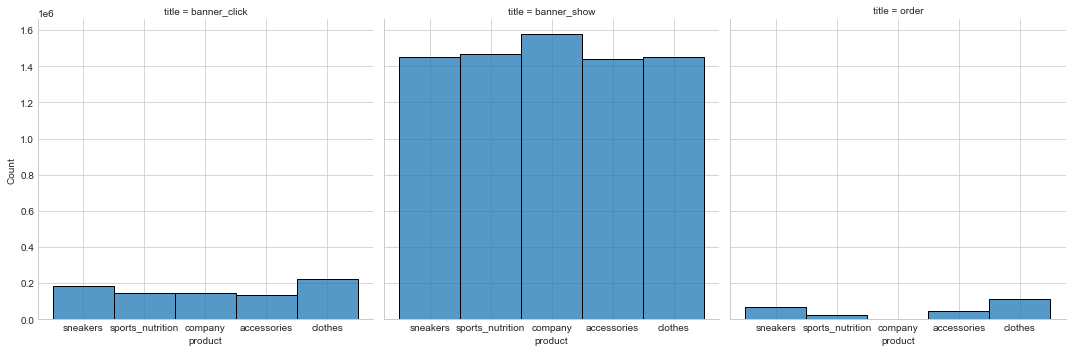

In [165]:
sns.displot(data=data, x='product', col='title')

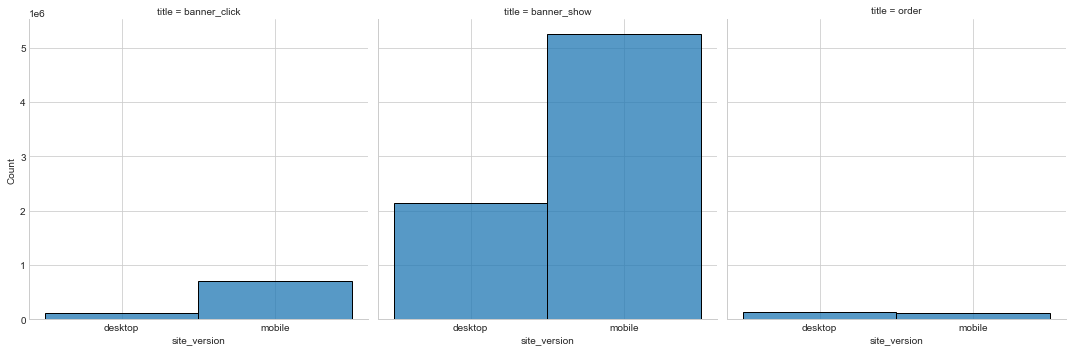

In [167]:
sns.displot(data=data, x='site_version', col='title')

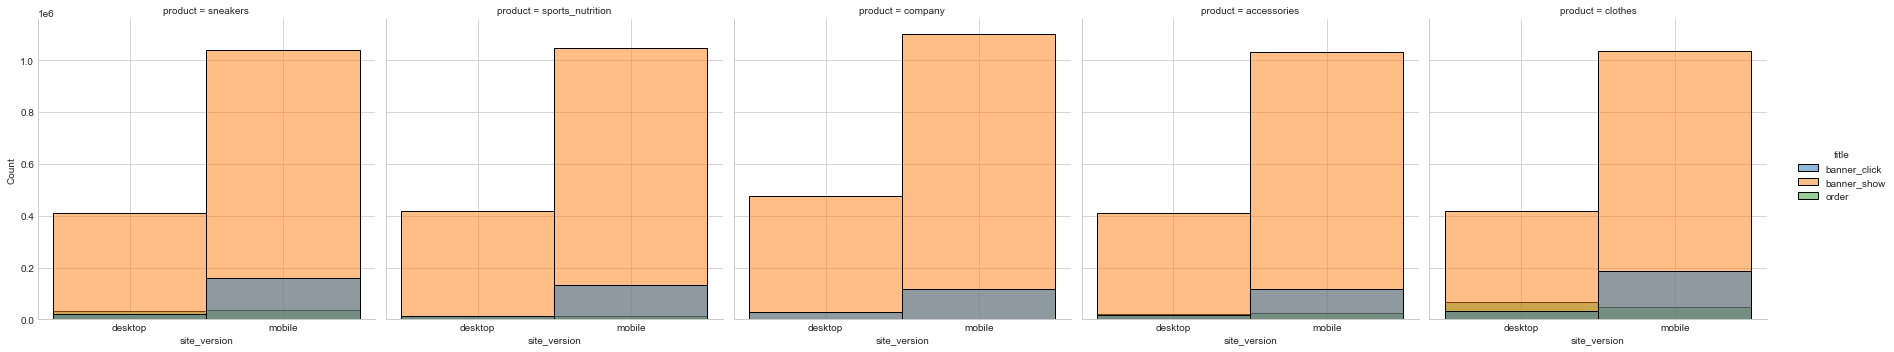

In [166]:
sns.displot(data=data, x='site_version', col='product', hue='title')

### Quick Findings:
Purchase popularity range from clothes -> sneakers -> accessories -> sport_nutrition -> company_product. \
It looks like nobody bought company product even though we showed the most banners for it.

### Retention Analysis 
There seems to be an equal number of orders for desktop and mobile. However, we have significantly more mobile users than site users. \

Here, the question is: which version is better at retaining visitors?

Our metric will be time_in_product, which will be defined as days_passed_since_last_visit. Our observed event will be whether someone is still a customer (ie- have they ever bought a product) 

In [169]:
mobile_data = data[data['site_version'] == 'mobile']
website_data = data[data['site_version'] == 'desktop']

In [174]:
mobile_retention_metrics = mobile_data.groupby(["user_id"]).agg(
         num_visits = ("target", "count")
        , num_purchases = ("target", lambda x: (x>0).sum())
        , days_since_first_appearance = ("datetime", lambda x: (x.max() - x.min()).days)
)
website_retention_metrics = website_data.groupby(["user_id"]).agg(
         num_visits = ("target", "count")
        , num_purchases = ("target", lambda x: (x>0).sum())
        , days_since_first_appearance = ("datetime", lambda x: (x.max() - x.min()).days)
)

In [181]:
def did_user_purchase(num_purchases):
    if num_purchases > 0:
        return 1 
    else:
        return 0
website_retention_metrics['customer'] = website_retention_metrics['num_purchases'].apply(did_user_purchase)
mobile_retention_metrics['customer'] = mobile_retention_metrics['num_purchases'].apply(did_user_purchase)

In [190]:
website_retention_metrics

,num_visits,num_purchases,days_since_first_appearance,customer
user_id,,,,
0000023f507999464aa2b78875b7e5d6,1,0,0,0
00000ce845c00cbf0686c992fc369df4,1,0,0,0
00000f7264c27ba6fea0c837ed6aa0aa,1,0,0,0
0000104cd168386a335ba6bf6e32219d,4,1,80,1
0000180e94707c0d90547614c17076bf,2,0,0,0
...,...,...,...,...
ffffa1dec2b5597706e69c9154d0da49,1,0,0,0
ffffad3f78f2b13ce571c709dd049cd3,1,0,0,0
ffffb8de2d77567f452ad766471a9e5e,1,0,0,0


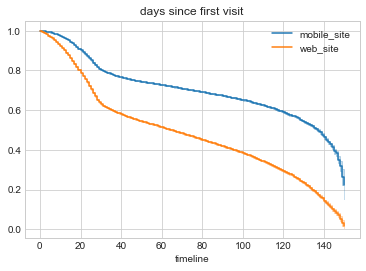

In [185]:
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

ax = plt.subplot(111)
kmf = KaplanMeierFitter()
kmf.fit(mobile_retention_metrics['days_since_first_appearance'], event_observed=mobile_retention_metrics['customer'], label="mobile_site")
kmf.plot_survival_function(ax=ax)

kmf.fit(website_retention_metrics['days_since_first_appearance'], event_observed=website_retention_metrics['customer'], label="web_site")
kmf.plot_survival_function(ax=ax)

plt.title("days since first visit");

In [188]:
from lifelines.statistics import logrank_test

results = logrank_test(mobile_retention_metrics['days_since_first_appearance'], website_retention_metrics['days_since_first_appearance']
                       , mobile_retention_metrics['customer'], website_retention_metrics['customer'], alpha=.99)
results.p_value

0.0

The mobile site is much better at retaining and converting people.

In [197]:
print('website : ', website_retention_metrics[website_retention_metrics['customer'] == 1].shape[0]
      / website_retention_metrics['customer'].count())
print('mobile : ', mobile_retention_metrics[mobile_retention_metrics['customer'] == 1].shape[0]
      / mobile_retention_metrics['customer'].count())

website :  0.08801688971989904
mobile :  0.039400291265499945


### Engagement Analysis
We need to assess banner performance. 

Our metric is click_through_rate := number_of_clicks/number_of_impressions. \\

Q1: is our click_through_rate different across mobile and site experience?

In [198]:
click_through_contingency_table = pd.crosstab(data['site_version'], data['title'])
click_through_contingency_table

title,banner_click,banner_show,order
site_version,,,
desktop,115065,2134639,133181
mobile,714119,5258675,115541


In [199]:
# apply chi_squared_test to check whether there is independence between desktop/site experience and banner clicks
# since a banner can only be clicked if it was shown, we need to correct for this in our table
import scipy.stats as stats

stats.chi2_contingency(np.array([[115065,2134639-115065], [714119,5258675-714119]]))

(102262.95201384179,
 0.0,
 1,
 array([[ 239406.64559574, 1895232.35440426],
        [ 589777.35440426, 4668897.64559574]]))

In [200]:
print('desktop ctr: ', 115065 / (2134639 - 115065))
print('mobile ctr: ', 714119 / (5258675 - 714119))

desktop ctr:  0.05697488678305425
mobile ctr:  0.15713724289017453


it looks like our mobile ctr is significantly better than website ctr

Q2: is ctr different across our products?

In [202]:
product_click_table = pd.crosstab(data['product'], data['title'])
product_click_table

title,banner_click,banner_show,order
product,,,
accessories,136254,1440954,44551
clothes,220595,1453128,112715
company,144821,1580235,0
sneakers,182596,1453027,67719
sports_nutrition,144918,1465970,23737


In [205]:
stats.chi2_contingency(np.array([[136254,1440954-136254]
                                , [220595,1453128-220595]
                                , [144821,1580235-144821]
                                , [182596,1453027-182596]
                                , [144918, 1465970-144918]]))

(39369.48642564484,
 0.0,
 4,
 array([[ 161607.63651267, 1279346.36348733],
        [ 162972.98985976, 1290155.01014024],
        [ 177228.44968305, 1403006.55031695],
        [ 162961.66238415, 1290065.33761585],
        [ 164413.26156038, 1301556.73843962]]))

In [206]:
print("accessories : ", 136254 / (1440954-136254))
print("clothes : ", 220595 / (1453128-220595))
print("company : ", 144821 / (1580235-144821))
print("sneakers : ", 182596 / (1453027-182596))
print("sports_nutrition : ", 144918 / (1465970-144918))

accessories :  0.1044332030351805
clothes :  0.17897695234123548
company :  0.100891450132157
sneakers :  0.1437276011054516
sports_nutrition :  0.10969893690785829


Our clothes and sneakers have higher ctr

### Revenue Analysis

In [209]:
# we want to determine whether our number of purchases between website and mobile is same
stats.kstest(mobile_retention_metrics['num_purchases'], website_retention_metrics['num_purchases'])

KstestResult(statistic=0.04861659845439914, pvalue=0.0)

our number of purchases between the mobile site and website is not drawn from the same distribution, as shown by the ks test

### Findings
We are shown banners equally across our product types, but the click-through-rate and purchases suggest popularity is as follows: clothes -> sneakers -> sports_nutrition ->  accessories -> company. \
Our company product has similiar ctr, but it is not converting to orders at all. It is gathering interest, but nobody is buying. There needs to be more data on what the company product is, since nothing is converting \
Website is performing poorly for both click-through-rate and conversions. The website needs to be re-examined in detail.